# Second Neural Network Architecture test

In [81]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf


## Data Preprocessing

In [124]:
def load_vehicle_data(vehicles_path='data'):
  csv_path = os.path.join(vehicles_path, "project_data.csv")
  return pd.read_csv(csv_path)

vehicles = load_vehicle_data()
vehicles.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


### Removing noisey data instances

In [83]:
# Removing outlier vehicle prices that are dramatically outside standard deviation
vehicles.drop(vehicles[vehicles['selling_price'] >= 1750000].index, inplace = True)

# Removing 'Test Drive Car' instances since it's NOT numerically related to other owner types
# AND NOT BEING USED FOR ONE HOT ENCODING
vehicles.drop(vehicles[vehicles['owner'] == 'Test Drive Car'].index, inplace = True)

# Since 'Electric' 'fuel' type since only 1 instance
vehicles.drop(vehicles[vehicles['fuel'] == 'Electric'].index, inplace = True)

### Convert categorical data to integers

In [84]:
# CREATING INTEGERS OF NUMBER OF OWNWERS
current_owner_strings = ['First Owner', 'Second Owner', 'Third Owner', 'Fourth & Above Owner']
new_owner_strings = ['1', '2', '3', '4']
vehicles['owner'] = vehicles['owner'].replace(current_owner_strings, new_owner_strings)
vehicles['owner'] = vehicles['owner'].astype('int64') # Convert type to integers:


# 0 index converting for category column's for future one-hot encoded data 

current_owner_strings = ['Petrol', 'Diesel', 'CNG', 'LPG']
new_strings = ['0', '1', '2', '3']
vehicles['fuel'] = vehicles['fuel'].replace(current_owner_strings, new_strings)
vehicles['fuel'] = vehicles['fuel'].astype('int64')


current_owner_strings = ['Individual', 'Dealer', 'Trustmark Dealer']
new_strings = ['0', '1', '2']
vehicles['seller_type'] = vehicles['seller_type'].replace(current_owner_strings, new_strings)
vehicles['seller_type'] = vehicles['seller_type'].astype('int64')


current_owner_strings = ['Manual', 'Automatic']
new_strings = ['0', '1']
vehicles['transmission'] = vehicles['transmission'].replace(current_owner_strings, new_strings)
vehicles['transmission'] = vehicles['transmission'].astype('int64')


In [123]:
vehicles.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,0,0,0,1
1,Maruti Wagon R LXI Minor,2007,135000,50000,0,0,0,1
2,Hyundai Verna 1.6 SX,2012,600000,100000,1,0,0,1
3,Datsun RediGO T Option,2017,250000,46000,0,0,0,1
4,Honda Amaze VX i-DTEC,2014,450000,141000,1,0,0,2


### Split 20% of data into 'test_set'

In [86]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(vehicles, test_size=0.2, random_state=42)

In [126]:
print(len(test_set))
print(len(train_set))

839
3355


### Create further subsets for multi input model

In [87]:
# Helper function to create a new data set containing 'data_set'
# elements in 'column_name_str' of data set and remove
# that column from 'data_set' input
def extract_data_column_inplace(data_set, column_name_str):
  data_column = data_set[[column_name_str]].copy()
  data_set.drop([column_name_str], axis=1, inplace = True)

  return data_column

Extract categorical data (`fuel`, `seller_type`, `transmission`) to be one hot encoded by model

In [88]:
# Copying and deleting data for one hot coding portion of model
train_set_one_hot_fuel = extract_data_column_inplace(train_set, 'fuel')
train_set_one_hot_seller_type = extract_data_column_inplace(train_set, 'seller_type')
train_set_one_hot_transmission = extract_data_column_inplace(train_set, 'transmission')

test_set_one_hot_fuel = extract_data_column_inplace(test_set, 'fuel')
test_set_one_hot_seller_type = extract_data_column_inplace(test_set, 'seller_type')
test_set_one_hot_transmission = extract_data_column_inplace(test_set, 'transmission')

Removing `name` attribute column from train_set/test_set

In [89]:
train_set_names = extract_data_column_inplace(train_set, 'name')
test_set_names = extract_data_column_inplace(test_set, 'name')

Extracting `selling_price` column as labels

In [90]:
train_set_labels = extract_data_column_inplace(train_set, 'selling_price')
test_set_labels = extract_data_column_inplace(test_set, 'selling_price')

Show new subset results of as they pertain to the train_set

In [91]:
# Could also compare using .head()
print("train_set: \r\n", train_set.columns)
print("train_set_one_hot_fuel: \r\n", train_set_one_hot_fuel.columns) 
print("train_set_one_hot_seller_type: \r\n", train_set_one_hot_seller_type.columns) 
print("train_set_one_hot_transmission: \r\n", train_set_one_hot_transmission.columns) 
print('train_set_names: \r\n', train_set_names.columns)
print('train_set_labels: \r\n', train_set_labels.columns)

train_set: 
 Index(['year', 'km_driven', 'owner'], dtype='object')
train_set_one_hot_fuel: 
 Index(['fuel'], dtype='object')
train_set_one_hot_seller_type: 
 Index(['seller_type'], dtype='object')
train_set_one_hot_transmission: 
 Index(['transmission'], dtype='object')
train_set_names: 
 Index(['name'], dtype='object')
train_set_labels: 
 Index(['selling_price'], dtype='object')


### `Mean Normalization` for numerical attributes to ensure attributes are equally weighted when passed into machine leanring model

In [92]:
train_set.head()

,year,km_driven,owner
2846,2012,62000,2
1249,2016,40000,1
4147,2013,49000,2
1904,2018,1452,1
3683,2015,70000,1


In [ ]:
# train_data = train_set['year','km_driven', 'owner']
# train_label = train

In [120]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit(train_set, train_set_labels) 
print(X_poly.get_feature_names_out(train_set.columns))

['year' 'km_driven' 'owner' 'year^2' 'year km_driven' 'year owner'
 'km_driven^2' 'km_driven owner' 'owner^2']


In [ ]:
# lin_reg = LinearRegression()
# lin_reg.fit(X_poly, y)

X_poly.intercept_, X_poly.coef_

In [93]:
normalized_train_set = (train_set-train_set.mean())/train_set.std()
normalized_test_set = (test_set-test_set.mean())/test_set.std()

In [94]:
normalized_train_set.head()

,year,km_driven,owner
2846,-0.230543,-0.101340,0.746987
1249,0.722007,-0.586263,-0.650749
4147,0.007595,-0.387886,0.746987
1904,1.198282,-1.435936,-0.650749
3683,0.483870,0.074995,-0.650749


## Transforming data into tensors for neural net architecture

In [95]:
train_set_tensor = tf.convert_to_tensor(normalized_train_set)
train_set_one_hot_fuel_tensor = tf.convert_to_tensor(train_set_one_hot_fuel)
train_set_one_hot_seller_type_tensor = tf.convert_to_tensor(train_set_one_hot_seller_type)
train_set_one_hot_transmission_tensor = tf.convert_to_tensor(train_set_one_hot_transmission)
train_set_names_tensor = tf.convert_to_tensor(train_set_names)
train_set_labels_tensor = tf.convert_to_tensor(train_set_labels)


test_set_tensor = tf.convert_to_tensor(normalized_test_set)
test_set_one_hot_fuel_tensor = tf.convert_to_tensor(test_set_one_hot_fuel)
test_set_one_hot_seller_type_tensor = tf.convert_to_tensor(test_set_one_hot_seller_type)
test_set_one_hot_transmission_tensor = tf.convert_to_tensor(test_set_one_hot_transmission)
test_set_names_tensor = tf.convert_to_tensor(test_set_names)
test_set_labels_tensor = tf.convert_to_tensor(test_set_labels)

# Create Model Architecture

## Model inputs [numerical values, fuel, seller_type, transmission, name], labels

In [96]:
import numpy as np

In [97]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Globals for word embedding's
EMBEDDING_DIMMENSIONS = 50
VOCARB_SIZE = 1550 # about 1427 unique names identified in dataset
MAX_LENGTH = 40 # approximate the largest vehicle name string


''' Handle data attributes ['year', 'km_driven', 'owner'] '''
numerical_inputs = tf.keras.layers.Input(shape=[3], dtype=tf.float32, name='year_kmDriven_owner_attributes')
# batch_numeric = tf.keras.layers.BatchNormalization()(numerical_inputs)


''' Handle 'name' attribute '''
name_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='name_attribute')

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCARB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LENGTH)
vectorize_layer.adapt(train_set_names) # Create vector table for data
# vectorize_layer.adapt(test_set_names)

vectorized_input = vectorize_layer(name_inputs)
name_embed = tf.keras.layers.Embedding(input_length=MAX_LENGTH, input_dim=VOCARB_SIZE, output_dim=EMBEDDING_DIMMENSIONS, name='embedding')(vectorized_input)
flattened_embedding = tf.keras.layers.Flatten()(name_embed)


''' Handle each one hot encoded input'''
# Handle and encode 'fuel' data
one_hot_input_fuel = tf.keras.layers.Input(shape=[1], dtype=tf.int64, name='fuel_attribute')
one_hot_encoder_fuel = tf.keras.layers.CategoryEncoding(num_tokens=4, output_mode='one_hot')(one_hot_input_fuel)

# Handle and encode 'seller_type' data
one_hot_input_seller_type = tf.keras.layers.Input(shape=[1], dtype=tf.int64, name='seller_type_attribute')
one_hot_encoder_seller_type = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode='one_hot')(one_hot_input_seller_type)

# Handle and encode 'seller_type' data
one_hot_input_transmission = tf.keras.layers.Input(shape=[1], dtype=tf.int64, name='transmission_attribute')
one_hot_encoder_transmission  = tf.keras.layers.CategoryEncoding(num_tokens=2, output_mode='one_hot')(one_hot_input_transmission)


''' Concatenate all data inputs together '''
all_inputs = tf.keras.layers.Concatenate()([flattened_embedding, numerical_inputs, one_hot_encoder_fuel, one_hot_encoder_seller_type, one_hot_encoder_transmission])


''' MODEL BODY  '''
first_dense = tf.keras.layers.Dense(512, kernel_initializer='he_normal', activation='relu')(all_inputs)
second_dense = tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')(first_dense)
third_dense = tf.keras.layers.Dense(128, kernel_initializer='he_normal', activation='relu')(second_dense)
fourth_dense = tf.keras.layers.Dense(64, kernel_initializer='he_normal', activation='relu')(third_dense)
fifth_dense = tf.keras.layers.Dense(32, kernel_initializer='he_normal', activation='relu')(fourth_dense)
sixth_dense = tf.keras.layers.Dense(8, kernel_initializer='he_normal', activation='relu')(fifth_dense)
seventh_dense = tf.keras.layers.Dense(4, kernel_initializer='he_normal', activation='relu')(sixth_dense)
output = tf.keras.layers.Dense(1, activation='linear')(seventh_dense)
model = tf.keras.Model(inputs=[name_inputs, numerical_inputs , one_hot_input_fuel, one_hot_input_seller_type, one_hot_input_transmission], outputs=[output])
ad_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
model.compile(optimizer=ad_optimizer, loss="mean_squared_error")

In [98]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
# history = model.fit([train_set_names_tensor, train_set_tensor, train_set_one_hot_fuel_tensor, train_set_one_hot_seller_type_tensor, train_set_one_hot_transmission_tensor], train_set_labels_tensor, callbacks=[early_stopping_cb], epochs=140, batch_size=32)

# Training with validation split
history = model.fit([train_set_names_tensor , train_set_tensor, train_set_one_hot_fuel_tensor, train_set_one_hot_seller_type_tensor, train_set_one_hot_transmission_tensor], train_set_labels_tensor, validation_split=0.2, callbacks=[early_stopping_cb], epochs=140, batch_size=32)

Epoch 1/140
84/84 [==============================] - 1s 5ms/step - loss: 233117138944.0000 - val_loss: 103126130688.0000
Epoch 2/140
84/84 [==============================] - 0s 4ms/step - loss: 86954786816.0000 - val_loss: 83530530816.0000
Epoch 3/140
84/84 [==============================] - 0s 4ms/step - loss: 68944060416.0000 - val_loss: 56046735360.0000
Epoch 4/140
84/84 [==============================] - 0s 4ms/step - loss: 40462192640.0000 - val_loss: 33439838208.0000
Epoch 5/140
84/84 [==============================] - 0s 4ms/step - loss: 27118729216.0000 - val_loss: 23884865536.0000
Epoch 6/140
84/84 [==============================] - 0s 4ms/step - loss: 20348694528.0000 - val_loss: 20271435776.0000
Epoch 7/140
84/84 [==============================] - 0s 4ms/step - loss: 16083319808.0000 - val_loss: 18090450944.0000
Epoch 8/140
84/84 [==============================] - 0s 4ms/step - loss: 13455514624.0000 - val_loss: 15769040896.0000
Epoch 9/140
84/84 [===========================

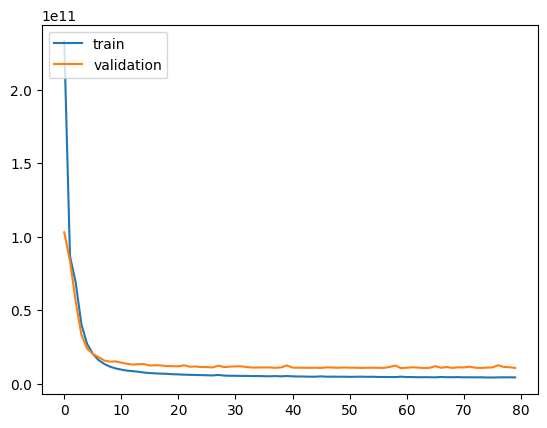

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

In [100]:
index = 0
percentage_totals = 0
for item in model.predict([test_set_names_tensor, test_set_tensor, test_set_one_hot_fuel_tensor, test_set_one_hot_seller_type_tensor, test_set_one_hot_transmission_tensor]):
  # print(f'(predicted, actual) = ({item[0]},{test_set_labels_tensor[index].numpy()})')
  # print(f"predicted - actual = {item[0] - test_set_labels_tensor[index].numpy()}")

  percentage_error = ((test_set_labels_tensor[index].numpy() - item[0]) / test_set_labels_tensor[index].numpy() ) * 100
  # print("percentage_error = ", percentage_error)

  percentage_totals += abs(percentage_error)
  
  index += 1



print("AVERAGE PERCENTAGE ERROR = ", percentage_totals / len(test_set_labels_tensor))

27/27 [==============================] - 0s 2ms/step
AVERAGE PERCENTAGE ERROR =  [21.21396685]


In [101]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Saving Model and Training data

In [102]:
tf.keras.Model.save(model, 'model_20_4_percentage_error')

INFO:tensorflow:Assets written to: model_20_4_percentage_error/assets


INFO:tensorflow:Assets written to: model_20_4_percentage_error/assets


In [103]:
new_mod = tf.keras.models.load_model('model_20_4_percentage_error')
index = 0
percentage_totals = 0
for item in new_mod.predict([test_set_names_tensor, test_set_tensor, test_set_one_hot_fuel_tensor, test_set_one_hot_seller_type_tensor, test_set_one_hot_transmission_tensor]):
  # print(f'(predicted, actual) = ({item[0]},{test_set_labels_tensor[index].numpy()})')
  # print(f"predicted - actual = {item[0] - test_set_labels_tensor[index].numpy()}")

  percentage_error = ((test_set_labels_tensor[index].numpy() - item[0]) / test_set_labels_tensor[index].numpy() ) * 100
  # print("percentage_error = ", percentage_error)

  percentage_totals += abs(percentage_error)
  
  index += 1



print("AVERAGE PERCENTAGE ERROR = ", percentage_totals / len(test_set_labels_tensor))

27/27 [==============================] - 0s 2ms/step
AVERAGE PERCENTAGE ERROR =  [21.21396685]


In [104]:
import pickle

with open('model_20_4_percentage_error_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Loading Model and Training data

In [105]:
# loaded_model = tf.keras.models.load_model('model_20_4_percentage_error')


In [106]:
# def load_pkl_model_history(pkl_file_name):
#     with open(pkl_file_name, "rb") as file_pi:
#         history = pickle.load(file_pi)

#     return history